In [1]:
import nltk
import os
from glob import glob
import json
from collections import defaultdict
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from text_processing import is_auto_message, preprocess_text
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "data\\mention_network_chats\\")
data_path


'c:\\Users\\andre\\Desktop\\Uni\\9sem\\02805 Social Graphs and Interactions\\Project\\social_graphs_project\\data\\mention_network_chats\\'

In [3]:
# Get all chat files
chat_files = list(glob(data_path + '*_chat.json'))
tokenized_chat = defaultdict(list)
print(f"Found {len(chat_files)} chat files to analyze\n")

for i, chat_file in tqdm(enumerate(chat_files), total=len(chat_files)):
    # Extract streamer name from filename
    filename = chat_file.split("\\")[-1].split(".")[0]  # Remove .json
    source_streamer = filename.rsplit('_', 2)[0].lower()  # First part is streamer name
    
    try:
        with open(chat_file, 'r', encoding='utf-8') as f:
            chat_data = json.load(f)       
        comments = chat_data.get('comments', [])
        for comment in tqdm(comments, desc=f"Processing comments for {source_streamer}"):
            fragments = comment['message']['fragments']
            if not fragments:
                continue
            if comment['message']['fragments'][0]['emoticon']:
                continue
            text = comment['message']['fragments'][0]['text']
            if is_auto_message(text):
                continue  # Skip auto messages
            tokens = preprocess_text(text, source_streamer)
            tokenized_chat[source_streamer] += tokens
    except Exception as e:
        print(f"[{i}/{len(chat_files)}] {source_streamer:15s}: Error - {e}")


Found 473 chat files to analyze



 41%|████      | 194/473 [06:37<07:35,  1.63s/it]

[194/473] jasontheween   : Error - Expecting value: line 1 column 1 (char 0)


100%|██████████| 473/473 [15:14<00:00,  1.93s/it]


In [4]:
streamer_comment = dict(tokenized_chat)

In [5]:
streamer_comment.keys(
)

dict_keys(['2xrakai', '39daph', 'abdulhd', 'aceu', 'adapt', 'admiralbahroo', 'agent00', 'agurin', 'ahmpy', 'alinity', 'alois_nl', 'alveussanctuary', 'amazonmusic', 'aminematue', 'angryginge13', 'anniefuchsia', 'anny', 'anomaly', 'anthonydaytv', 'arky', 'arrav', 'arrowcs', 'arteezy', 'asianbunnyx', 'aspen', 'atrioc', 'august', 'aurateur', 'aussieantics', 'austinmcbroom', 'auteru', 'auziomf', 'avoidingthepuddle', 'aztecross', 'b0aty', 'bagginstv', 'ballerleagueuk', 'bao', 'barbarousking', 'bawkbasoup', 'bbreadman', 'bean', 'bendadonnn', 'ben_', 'beterbabbit', 'bigpuffer', 'blastdotab', 'blastdota', 'bluesr', 'bobbypoffgaming', 'bobross', 'bonnie', 'boxbox', 'bozevstheworld', 'broxah', 'brucedropemoff', 'buffpup', 'bugs', 'caedrel', 'calebhart42', 'call of duty', 'camila', 'captainlance9', 'carolinekwan', 'caseoh_', 'cashout', 'casinodaddy', 'castro_1021', 'ccp', 'cdawg', 'cdnthe3rd', 'central_committee', 'chess', 'chibidoki', 'chilledchaos', 'chloe__irl', 'choc', 'cinna', 'clashroyale', 

In [6]:
streamer_map = {i: streamer for i, streamer in enumerate(list(streamer_comment.keys()))} 

In [7]:
streamer_chats = [" ".join(chat) for chat in list(streamer_comment.values())]

In [ ]:
streamer_chats

In [9]:

tfidf_vectorizer = TfidfVectorizer()  

tfidf = tfidf_vectorizer.fit_transform(streamer_chats)

words = tfidf_vectorizer.get_feature_names_out()

In [10]:
# streamer_map

In [ ]:
def show_wordcloud(streamer, tfidf_vector):
    scores = tfidf_vector.toarray()[0]
    word_scores = {words[i]: scores[i] for i in range(len(words))}
    
    wc = WordCloud(width=800, height=400).generate_from_frequencies(word_scores)
    
    plt.imshow(wc)
    plt.axis("off")
    plt.title(streamer)
    plt.show()
for idx in range(len(streamer_comment)):
    show_wordcloud(streamer_map[idx], tfidf[idx])

In [14]:
communities_partition = json.load(open(root_path + '\\data\\communities.json'))


In [15]:
from collections import defaultdict

streamers_in_community = defaultdict(list)

for streamers, community in communities_partition['partition'].items():
    streamers_in_community[community].append(streamers)

streamers_in_community = dict(streamers_in_community)

In [21]:
for community, streamers in streamers_in_community.items():
    print(f"Community {community}: {len(streamers)} streamers")

Community 0: 34 streamers
Community 1: 53 streamers
Community 2: 86 streamers
Community 3: 10 streamers
Community 4: 46 streamers
Community 5: 39 streamers
Community 6: 21 streamers
Community 7: 90 streamers
Community 8: 14 streamers
Community 9: 52 streamers
Community 10: 3 streamers
Community 11: 12 streamers
Community 13: 1 streamers
Community 14: 1 streamers
Community 15: 1 streamers
Community 16: 1 streamers
Community 17: 1 streamers
Community 18: 1 streamers
Community 19: 1 streamers
Community 20: 1 streamers
Community 21: 1 streamers
Community 22: 1 streamers
Community 23: 1 streamers
Community 24: 1 streamers
Community 25: 1 streamers
Community 26: 2 streamers
Community 27: 1 streamers
Community 28: 2 streamers
Community 29: 1 streamers
Community 30: 1 streamers
Community 31: 1 streamers
Community 32: 1 streamers
Community 33: 1 streamers
Community 34: 1 streamers
Community 35: 1 streamers
Community 36: 1 streamers
Community 37: 1 streamers
Community 38: 1 streamers
Community 3

In [19]:
communities_texts = []
community_map = {}
for idx, (community, streamers) in enumerate(streamers_in_community.items()):
    community_text = ""
    for streamer in streamers:
        try:
            community_text += " ".join(streamer_comment[streamer]) + " "
        except KeyError:
            print(f"Streamer {streamer} not found in streamer_comment")
           
    communities_texts.append(community_text)
    community_map[community] = idx

Streamer lplenglish not found in streamer_comment
Streamer jasontheween not found in streamer_comment
Streamer tarzaned not found in streamer_comment
Streamer asmongold247 not found in streamer_comment
Streamer camy not found in streamer_comment
Streamer silky not found in streamer_comment
Streamer riotgames not found in streamer_comment
Streamer callofduty not found in streamer_comment
Streamer primevideo not found in streamer_comment
Streamer rifftrax not found in streamer_comment
Streamer ray not found in streamer_comment
Streamer cohh not found in streamer_comment
Streamer thunderpicktv not found in streamer_comment
Streamer unboxholics not found in streamer_comment
Streamer theburntpeanut_247 not found in streamer_comment
Streamer donerlan not found in streamer_comment
Streamer primevision not found in streamer_comment
Streamer caseoh247 not found in streamer_comment
Streamer hazirb not found in streamer_comment
Streamer lirik_247 not found in streamer_comment
Streamer fredagainag

In [22]:
tfidf_vectorizer = TfidfVectorizer()  

tfidf = tfidf_vectorizer.fit_transform(communities_texts)

words = tfidf_vectorizer.get_feature_names_out()

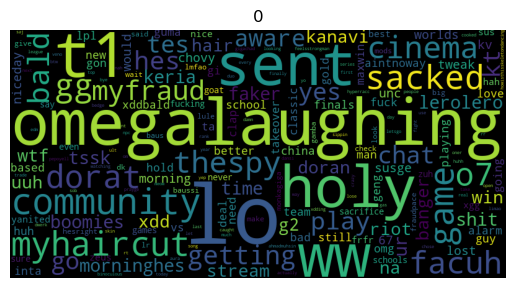

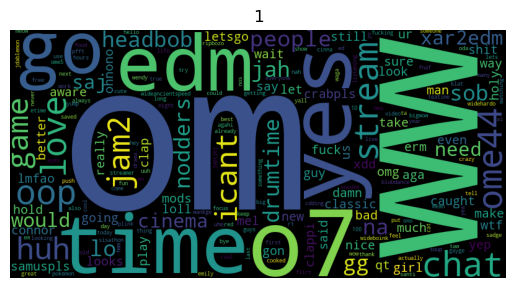

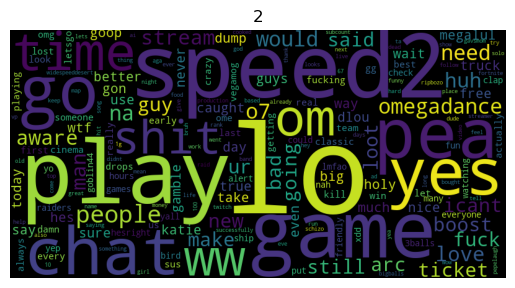

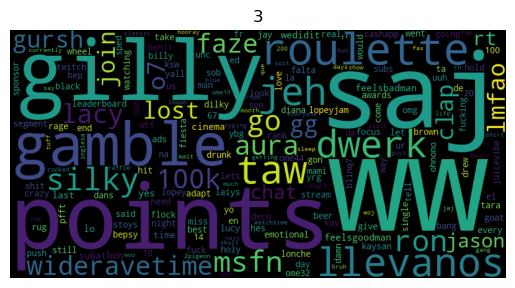

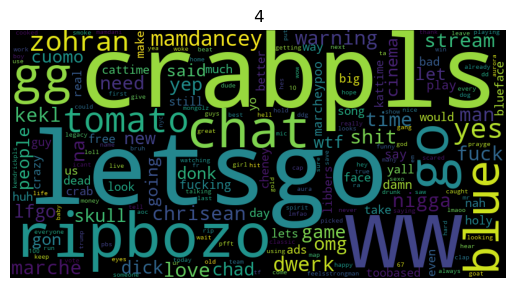

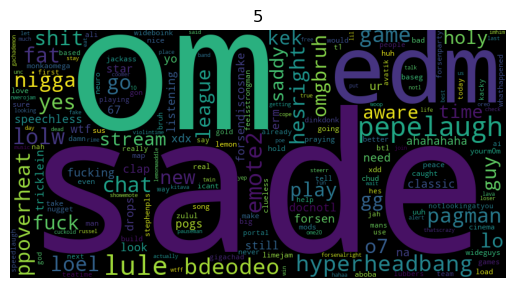

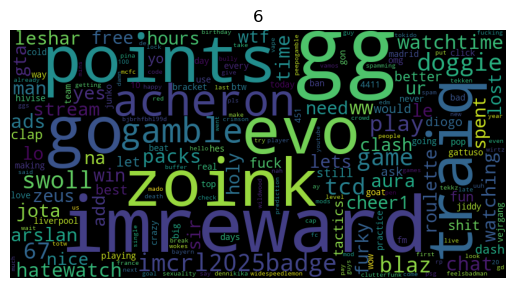

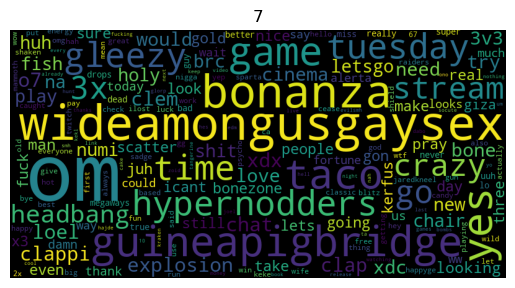

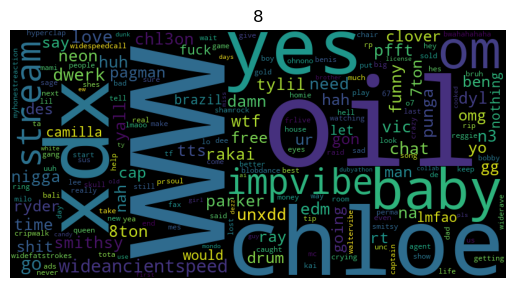

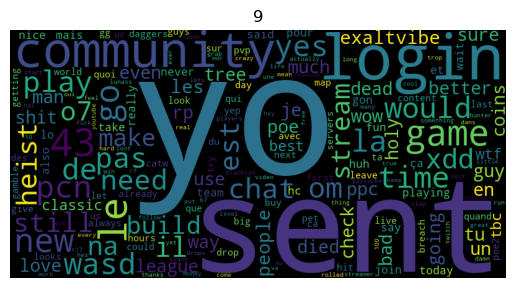

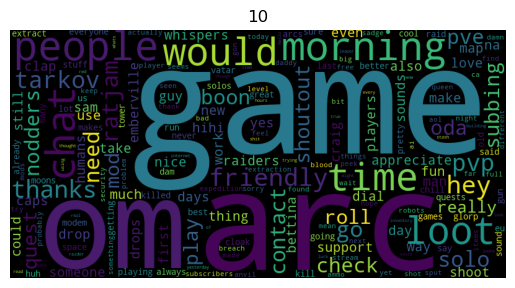

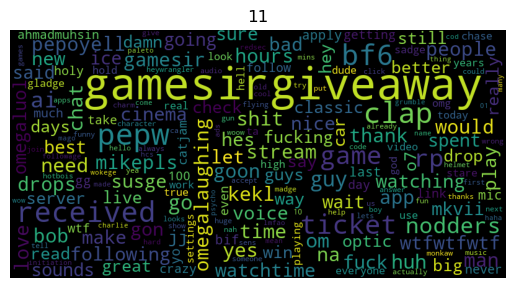

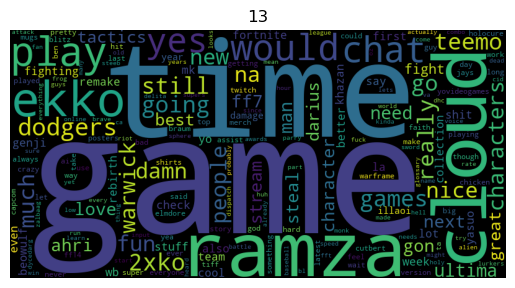

c:\Users\andre\miniconda3\envs\02805\Lib\site-packages\wordcloud\wordcloud.py:417: RuntimeWarning: invalid value encountered in scalar divide
  frequencies = [(word, freq / max_frequency)


ValueError: cannot convert float NaN to integer

In [23]:
def show_wordcloud(streamer, tfidf_vector):
    scores = tfidf_vector.toarray()[0]
    word_scores = {words[i]: scores[i] for i in range(len(words))}
    
    wc = WordCloud(width=800, height=400).generate_from_frequencies(word_scores)
    
    plt.imshow(wc)
    plt.axis("off")
    plt.title(streamer)
    plt.show()
for idx in range(len(communities_texts)):
    show_wordcloud(list(community_map.keys())[idx], tfidf[community_map[list(community_map.keys())[idx]]])